In [1]:
using CausalForest
using StatsBase
using Plots
using Random
using Distributions
using RCall
using BenchmarkTools
using DelimitedFiles

In [2]:
Random.seed!(123);
n, m = 10^4, 10;
u = Uniform(0,10);
features = rand(u, (n, m));
X = features;
d = Normal();
eps = rand(d, n);
b = Bernoulli();
T = convert(Vector{Int64},rand(b, n));
Y = 125*sin.(features*[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]).*T  + features*[0, 0, 2, 0, 0, 0, 3, 0, 0, 0];

In [3]:
df = hcat(X,T,Y)

10000×12 Matrix{Float64}:
 9.063     0.273863  9.2398     5.83606   …  8.61508   1.0    76.6205
 4.43494   8.65398   4.38668    8.66793      5.79587   0.0    10.2415
 7.45673   7.98071   9.35901    5.96536      9.99516   0.0    27.5137
 5.12083   8.25448   8.79223    2.87236      8.06585   0.0    24.796
 2.53849   5.30423   5.84012    9.7704       9.6668    0.0    22.6625
 3.34152   2.66141   9.8669     9.76664   …  9.49805   1.0     0.498469
 4.27328   8.75436   0.0258112  0.863643     2.24987   1.0  -104.14
 8.67547   7.27313   0.151025   4.99536      0.765286  0.0    25.0373
 0.991336  1.20752   5.87184    3.17045      9.81301   0.0    20.8175
 1.25287   6.88003   3.64868    5.80333      3.00126   0.0    26.2578
 6.92209   0.298644  4.84843    8.11503   …  1.49476   0.0    36.4211
 1.36551   1.07227   0.570038   1.05282      7.60498   1.0   143.365
 0.320967  6.45858   4.85281    2.0843       1.98433   0.0    32.6943
 ⋮                                        ⋱            ⋮    
 1.41

In [4]:
#header = ["X1" "X2" "X3" "X4" "X5" "X6" "X7" "X8" "X9" "X10" "T" "Y"]
#writedlm("sinus_causal_5.csv", [header ; df], ",")

In [5]:
reval("set.seed(1)")
Xtest_1 = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
true_effect_1 = 125*sin.(Xtest_1[:, 1]);

In [6]:
function get_all_nodes_in_tree!(
    tree ,
    depth = 3,
    result  = []
    )
    if hasproperty(tree, :featid) && depth > 0
        push!(result, tree.featid)
        get_all_nodes_in_tree!(tree.left, depth-1, result)
        get_all_nodes_in_tree!(tree.right, depth-1, result)
    end
    return result
end

function get_freq(forest, depth=3) 
    ensemble = forest.trees
    n_trees = length(ensemble)
    res = []
    for i = 1:n_trees
        append!(res, get_all_nodes_in_tree!(forest.trees[i].tree, depth))
    end
    return proportionmap(res)
end

get_freq (generic function with 2 methods)

# Critère nouveau

### Subsampling

In [7]:
errors_11 = zeros(100)

cf = build_forest(false, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_11[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 125*sin.(Xtest[:, 1])
    errors_11[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_11))
println(var(errors_11))

0.4760525619861533
0.0002992626490921151


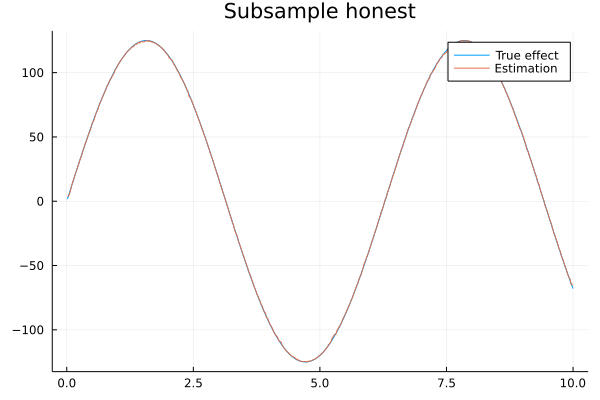

In [8]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Subsample honest", fmt = :png)

In [9]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [10]:
get_freq(cf, 5)

Dict{Any, Float64} with 8 entries:
  4  => 6.48046e-5
  6  => 0.000259218
  7  => 6.48046e-5
  2  => 6.48046e-5
  10 => 0.000129609
  9  => 6.48046e-5
  8  => 0.000129609
  1  => 0.999222

In [11]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.00560925
  4  => 0.00532464
  6  => 0.0065461
  7  => 0.00536021
  2  => 0.00610732
  10 => 0.00616662
  9  => 0.00545508
  8  => 0.00633264
  3  => 0.00583457
  1  => 0.947264

### Bootstrap

In [12]:
errors_12 = zeros(100)

cf = build_forest(true, true, Y, T, X, true, 10, 500, 500)
pred = apply_forest(cf, Xtest_1)
errors_12[1] = rmsd(float(true_effect_1), pred)
for i in 2:100
    @rput i
    reval("set.seed(i)")
    Xtest = rcopy(R"matrix(runif(10000,0,10),nrow=1000)")
    pred = apply_forest(cf, Xtest)
    true_effect = 125*sin.(Xtest[:, 1])
    errors_12[i] = rmsd(float(true_effect), pred)
end
println(mean(errors_12))
println(var(errors_12))

1.21096144278919
0.0012402844492717885


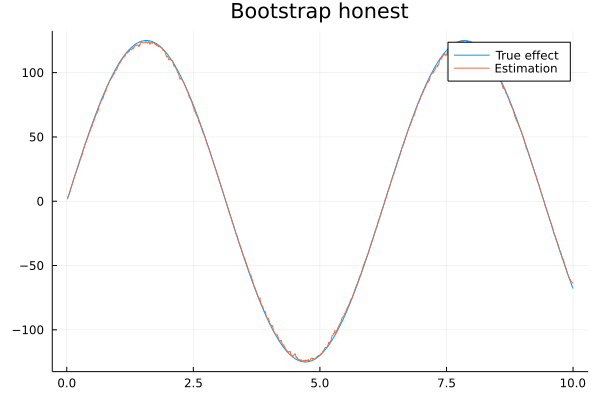

In [13]:
ind = sortperm(Xtest_1[:, 1])
pred = apply_forest(cf, Xtest_1)
plot(Xtest_1[ind, 1], [true_effect_1[ind], pred[ind]], label=["True effect" "Estimation"], title = "Bootstrap honest", fmt = :png)

In [14]:
get_freq(cf, 3)

Dict{Any, Float64} with 1 entry:
  1 => 1.0

In [15]:
get_freq(cf, 5)

Dict{Any, Float64} with 10 entries:
  5  => 6.47501e-5
  4  => 0.00019425
  6  => 0.000259
  7  => 0.000259
  2  => 0.00019425
  10 => 0.000518001
  9  => 0.00019425
  8  => 0.00032375
  3  => 0.0003885
  1  => 0.997604

In [16]:
get_freq(cf, 10)

Dict{Any, Float64} with 10 entries:
  5  => 0.0129049
  4  => 0.0125837
  6  => 0.0138213
  7  => 0.0136324
  2  => 0.0130844
  10 => 0.0137079
  9  => 0.0130655
  8  => 0.0133962
  3  => 0.013963
  1  => 0.879841